In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range
import time
from scipy.special import logsumexp
from scipy.stats import truncnorm
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [3]:
# import models
from brutus import seds
filters = seds.gaia + seds.ps + seds.tmass
f = h5py.File('data/grid_v4.h5')
params = f['parameters'][:]
labels = f['labels'][:]
mag_coeffs = f['mag_coeffs']
models = np.zeros((len(labels), len(filters), len(mag_coeffs[0][0])), dtype='float32')
for i, filt in enumerate(filters):
    sys.stderr.write('\rReading filter {}              '.format(filt))
    models[:, i] = mag_coeffs[filt]  # fitted magnitude coefficients
Nmodels, Nbands, Ncoef = models.shape

Reading filter 2MASS_Ks                    

In [4]:
# combine labels
lnames = ['mini', 'feh', 'loga', 'logl', 'logt', 'logg']
combined_params = np.zeros(Nmodels, dtype=np.dtype([(n, np.float) for n in lnames]))
for n in labels.dtype.names:
    if n in lnames:
        combined_params[n] = labels[n]
for n in params.dtype.names:
    if n in lnames:
        combined_params[n] = params[n]

In [5]:
# load in data
from frankenz.pdf import inv_magnitude
f = h5py.File('data/GaiaHackWeek.00000.h5')
fpix = f['photometry']['pixel 128-32188']
mag, magerr = fpix['mag'], fpix['err']
phot, err = inv_magnitude(mag, magerr)
mask = ~np.isclose(mag, 0.)
objid = fpix['obj_id']
parallax, parallax_err = fpix['parallax'], fpix['parallax_error']
psel = np.isnan(parallax) | np.isnan(parallax_err) | np.isclose(parallax_err, 0.)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[fpix['l'], fpix['b']]

Nobjs = len(phot)

In [6]:
# load in fitter
from brutus.fitting import BruteForce
BF = BruteForce(models[:, 3:], labels, models_params=params, 
                avgrid=np.linspace(0., 6., 15.))

In [7]:
Nsub = 10

# without gaia
t1 = time.time()
BF.fit(phot[:Nsub], err[:Nsub], mask[:Nsub], objid[:Nsub], 'data/GaiaHackWeek.00000_nogaia_v4',
       data_coords=coords[:Nsub])
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nsub)

Fitting object 10/10


Avg time per object: 18.2001221895


In [8]:
# with gaia
t1 = time.time()
BF.fit(phot[:Nsub], err[:Nsub], mask[:Nsub], objid[:Nsub], 'data/GaiaHackWeek.00000_yesgaia_v4', 
       parallax=parallax[:Nsub], parallax_err=parallax_err[:Nsub], data_coords=coords[:Nsub])
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nsub)

Fitting object 10/10


Avg time per object: 18.8825801849


In [9]:
# load in results (no gaia)
f = h5py.File('data/GaiaHackWeek.00000_nogaia_v4.h5')
s_ng = f['scales'][:]
av_ng = f['avs'][:]
cov_ng = f['cov_sa'][:]
idxs_ng = f['idxs'][:]
chi2_ng = f['best_chi2'][:]
levid_ng = f['log_evidence'][:]

# load in results (w/ gaia)
f = h5py.File('data/GaiaHackWeek.00000_yesgaia_v4.h5')
s_yg = f['scales'][:]
av_yg = f['avs'][:]
cov_yg = f['cov_sa'][:]
idxs_yg = f['idxs'][:]
chi2_yg = f['best_chi2'][:]
levid_yg = f['log_evidence'][:]

Best-fit chi2: 0.0559108


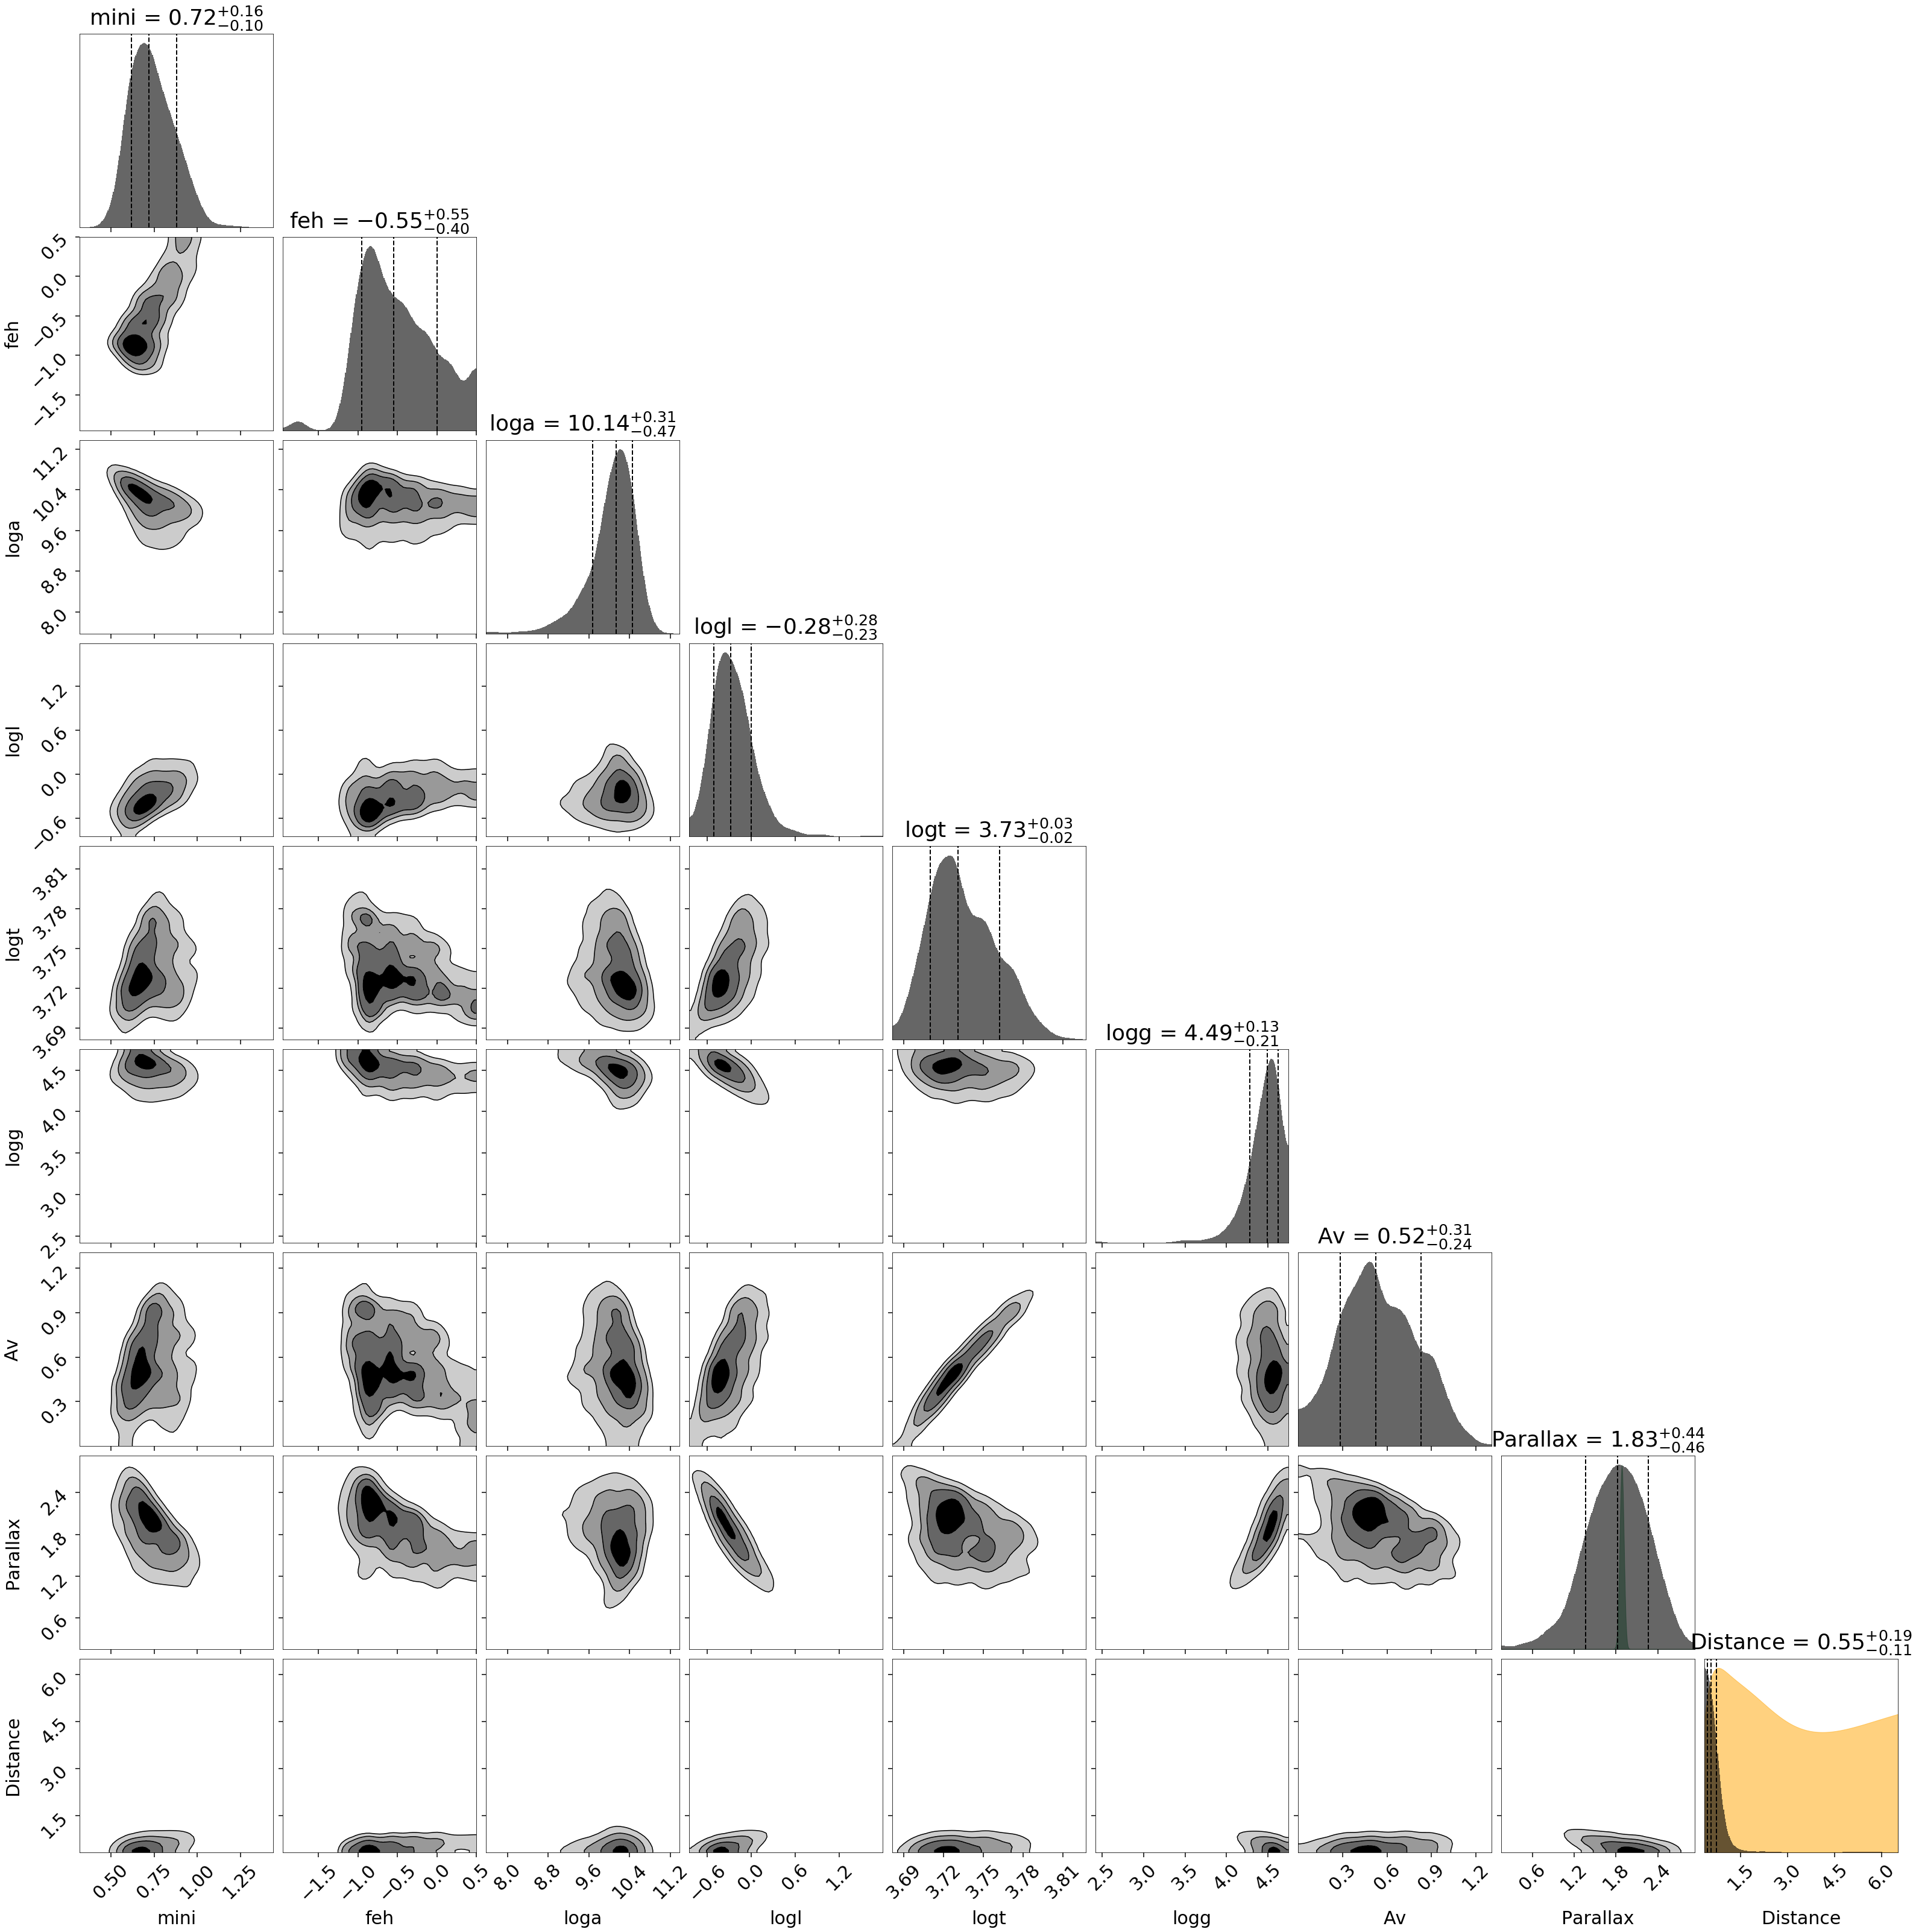

In [12]:
# plot snapshot of results
from brutus import plotting as bplot

i = 1

# without gaia
print('Best-fit chi2:', chi2_ng[i])
fig, axes = bplot.cornerplot(idxs_ng[i], s_ng[i], av_ng[i], cov_ng[i],
                             combined_params, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=False, pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(9, 9, figsize=(45, 45)))

Best-fit chi2: 0.0559108


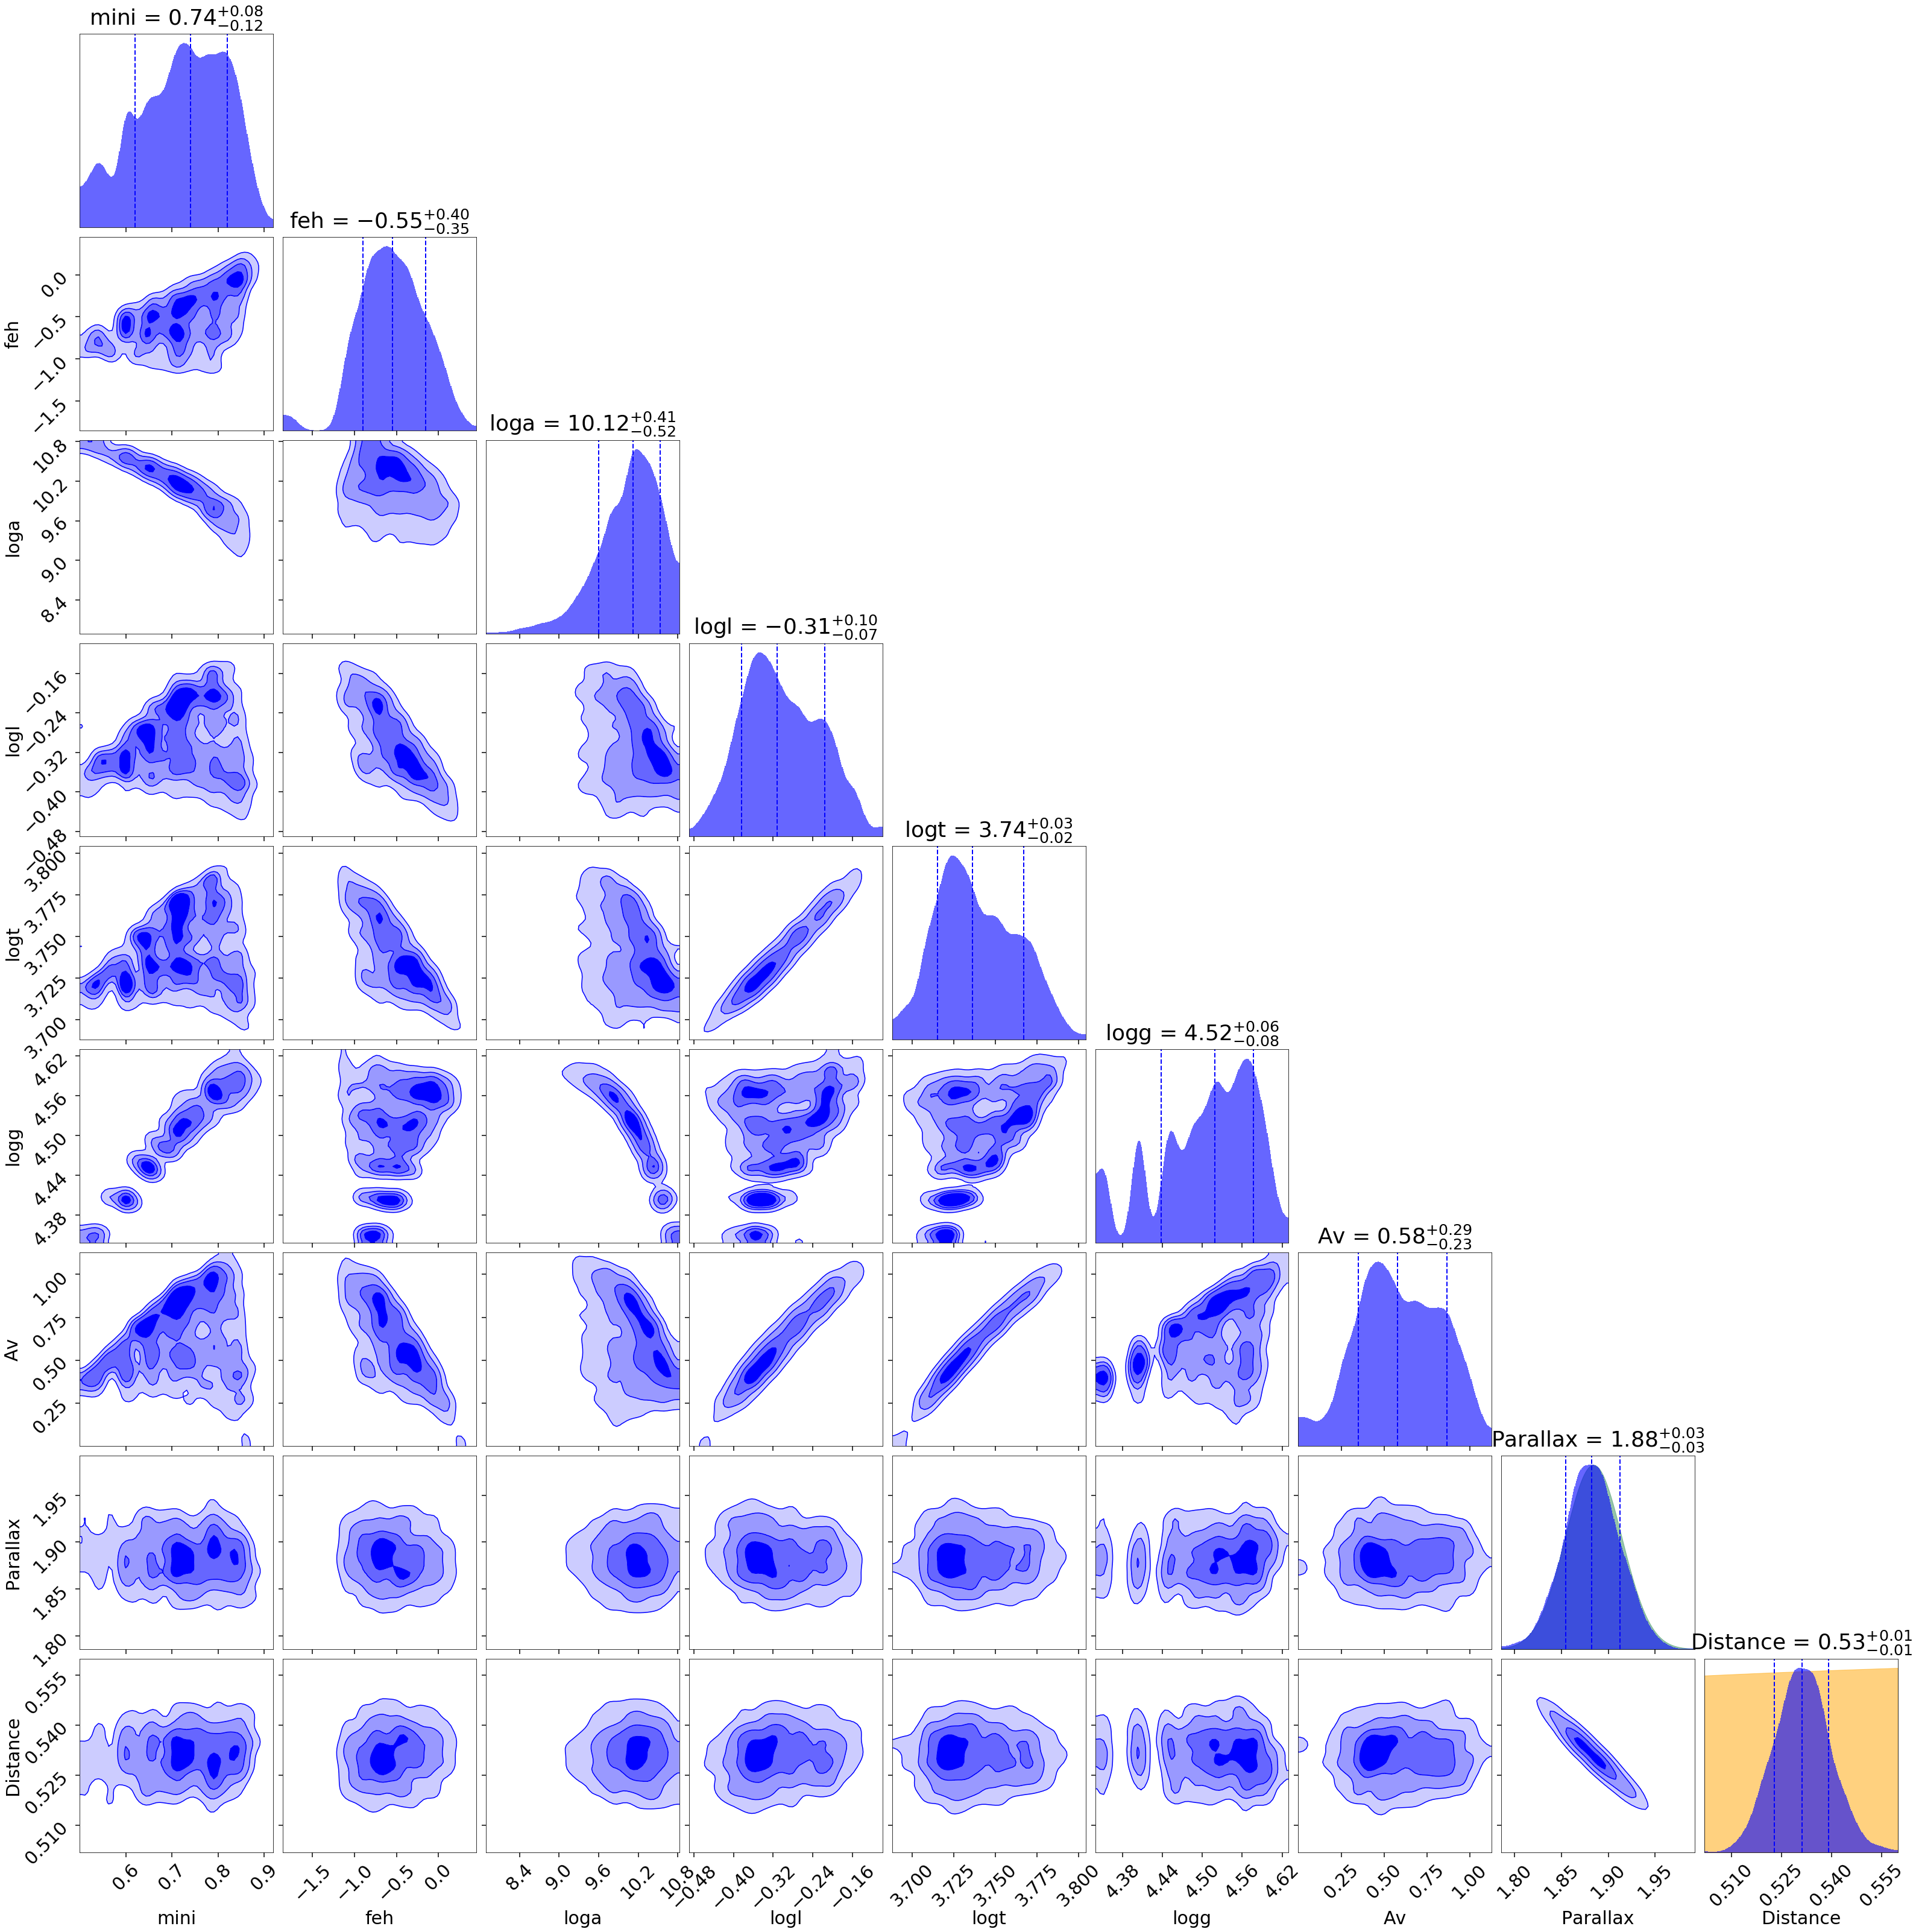

In [13]:
# with gaia
print('Best-fit chi2:', chi2_yg[i])
fig, axes = bplot.cornerplot(idxs_yg[i], s_yg[i], av_yg[i], cov_yg[i],
                             combined_params, color='blue', coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=True, pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(9, 9, figsize=(45, 45)))